### KPI och visualisering
- MRR (Monthly Recurring Revenue) - Ekonomisk hälsa

- Churn Rate & Retention - Medlemslojalitet

- Gymfrekvens - Engagemangsnivå

- Passbeläggning - Operativ effektivitet

- Kundnöjdhet - Betyg + sentiment

- Medlemstyp Analys - Segmentprofitabilitet

**Varför just dessa?**

- Balanserade (ekonomi, kund, operativt)

- Visualiserbara (perfekt för seaborn/matplotlib)

- Relevanta för gymbranschen

- Möjliga att implementera med din data

- Passar sentimentanalys (feedback_text)


In [1]:
# Importera bibliotek
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import pipeline
import torch


C:\Users\johan\AppData\Roaming\Python\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# device=0 använder GPU, device=-1 använder CPU
# Ladda sentimentmodellen
classifier = pipeline(
    "sentiment-analysis",
    model="KBLab/robust-swedish-sentiment-multiclass",
    device=0 if torch.cuda.is_available() else -1
)

Loading weights: 100%|██████████| 393/393 [00:00<00:00, 801.62it/s, Materializing param=classifier.weight]                                  
MegatronBertForSequenceClassification LOAD REPORT from: KBLab/robust-swedish-sentiment-multiclass
Key                          | Status     |  | 
-----------------------------+------------+--+-
bert.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [3]:
# Läs in all data från SQLite
conn = sqlite3.connect('friskvard_data_cleaned.db')
df_all = pd.read_sql('SELECT * FROM friskvard_data', conn)
conn.close

# Skapa en kopia för feature engineering
df_feat = df_all.copy()

In [10]:
df_feat.value_counts()

bokning_id  medlem_id  medlemstyp  medlem_startdatum  medlem_slutdatum  månadskostnad  födelseår  pass_id              passnamn  anläggning           instruktör       bokningsdatum        passdatum   passtid          status     feedback_text                                            feedbackdatum        feedback_betyg  är_negativt_belopp  månadskostnad_abs  pass_year  pass_month  pass_week  pass_ym  kostnad_bin  ear   month  week  ym       region_Syd  region_Väst  region_Öst  region_Övrigt  region
BOK-000001  MED-10158  Premium     2023-07-29         2025-03-07        599            2006.0     PASS-2024-10-01-001  Yoga      Göteborg Centrum     Maria Santos     2024-09-24 00:00:00  2024-01-10  11:00:00.000000  Genomförd  Bästa yogapasset jag varit på. Kommer tillbaka!          2024-02-10 00:00:00  4.0             0                   599                2024       1           2          2024-01  500-599      2024  1      2     2024-01  False       True         False       False         

In [19]:
# =============== Feature Engineering =================

# Säkerställ datumtyper
for col in ['passdatum', 'medlem_startdatum', 'medlem_slutdatum']:
    if col in df_feat.columns:
        df_feat[col] = pd.to_datetime(df_feat[col], errors='coerce')

# Tidsfeatures
if 'passdatum' in df_feat.columns:
    df_feat['year'] = df_feat['passdatum'].dt.year
    df_feat['month'] = df_feat['passdatum'].dt.month
    df_feat['week'] = df_feat['passdatum'].dt.isocalendar().week.astype('int64')
    df_feat['day'] = df_feat['passdatum'].dt.day
    df_feat['ym'] = df_feat['passdatum'].dt.to_period('M').astype(str)

# Binning (om kolumner finns)
if 'månadskostnad_abs' in df_feat.columns:
    df_feat['kostnad_bin'] = pd.cut(
        df_feat['månadskostnad_abs'],
        bins=[0, 199, 299, 399, 499, 599, 9999],
        labels=['<=199','200-299','300-399','400-499','500-599','600+']
    )

# Regionkartläggning
def map_region(df):
    region_map = {
        # ÖST (Mälardalen/Stockholm)
        'Stockholm City': 'Öst',
        'Stockholm Södermalm': 'Öst',
        'Stockholm Kungsholmen': 'Öst',
        'Uppsala': 'Öst',
        'Västerås': 'Öst',
        'Örebro': 'Öst',

        # VÄST
        'Göteborg Centrum': 'Väst',
        'Göteborg Hisingen': 'Väst',
        
        # SYD (Skåne & Östergötland)
        'Linköping': 'Syd',
        'Malmö Centrum': 'Syd',
        'Malmö Västra Hamnen': 'Syd',
        'Lund': 'Syd',
        
        'Okänd': 'Övrigt'
    }
    df_feat = df.copy()    
    df_feat['region'] = df_feat['anläggning'].map(region_map)
    return df_feat

df_feat = map_region(df_feat)

# One-hot encoding
one_hot_cols = [c for c in ['medlemstyp'] if c in df_feat.columns]
if one_hot_cols:
    df_feat = pd.get_dummies(df_feat, columns=one_hot_cols, prefix=one_hot_cols, drop_first=False)


Analyserar för månad: 2025-12

 MRR (Monthly Recurring Revenue) & CHURN RATE (2025-12)
MRR: 2,344 SEK
Churn Rate: 3.7%
Aktiva medlemmar: 6
Avslutade denna månad: 14

ENGAGEMANG (2025-12)
Genomsnittliga besök/medlem: 1.0
Andel med 3+ besök/månad: 0.0%
Totalt antal pass: 13


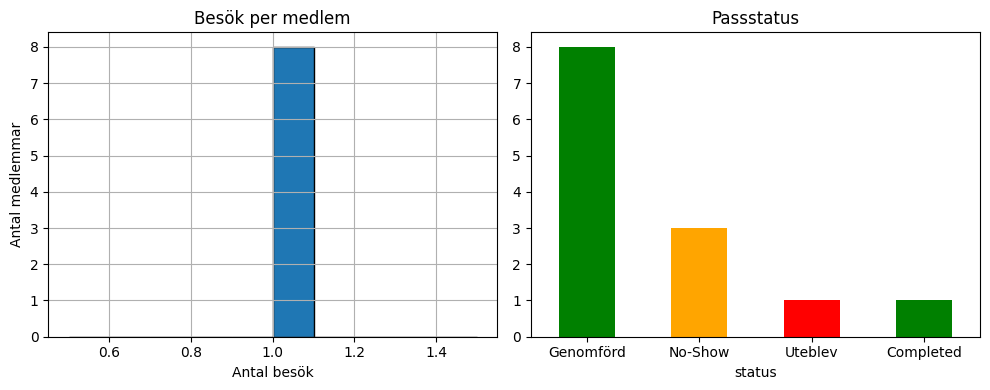


REGIONAL ANALYS
Regional statistik:
        Antal medlemmar  Avg kostnad  Avg betyg
region                                         
Syd                 353        401.7        3.7
Väst                286        414.8        4.1
Öst                 370        417.0        3.7
Övrigt               95        401.3        3.8


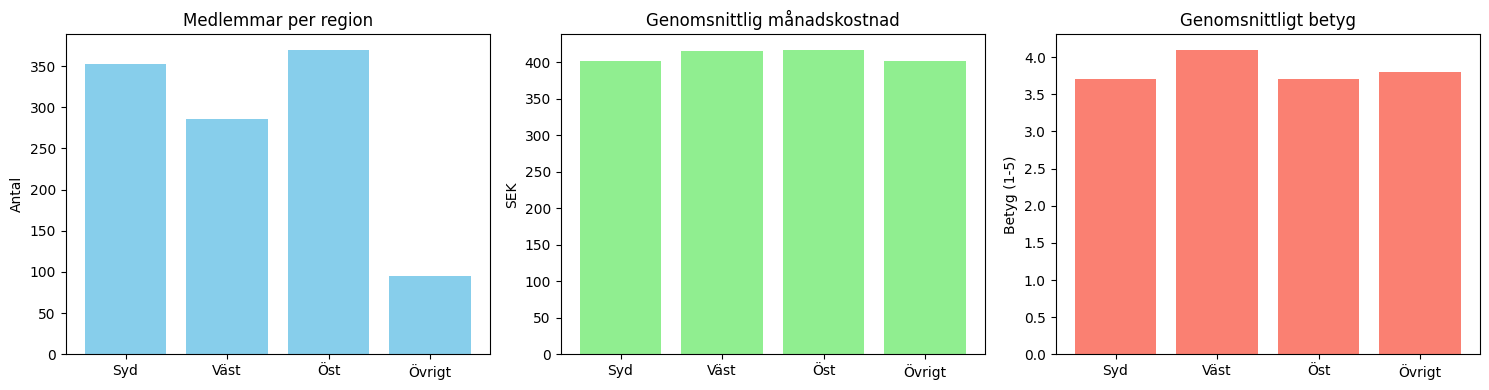


PASSBELÄGGNING (2025-12)
Passbeläggning:
          total_bookings  completed  utilization
passnamn                                        
Dans                   2          2          8.0
Hiit                   2          2          8.0
Pilates                3          1          4.0
Spinning               3          1          3.3
Yoga                   3          2         10.0


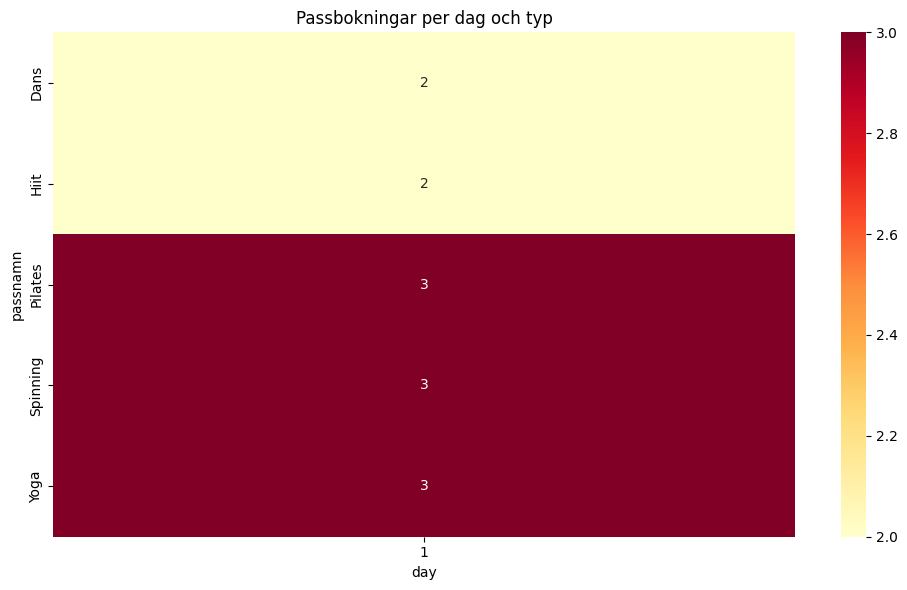


KUNDNÖJDHET
Genomsnittligt betyg: 3.81/5

Sentimentfördelning:
  neutral: 87.0%
  positive: 11.9%
  negative: 1.1%


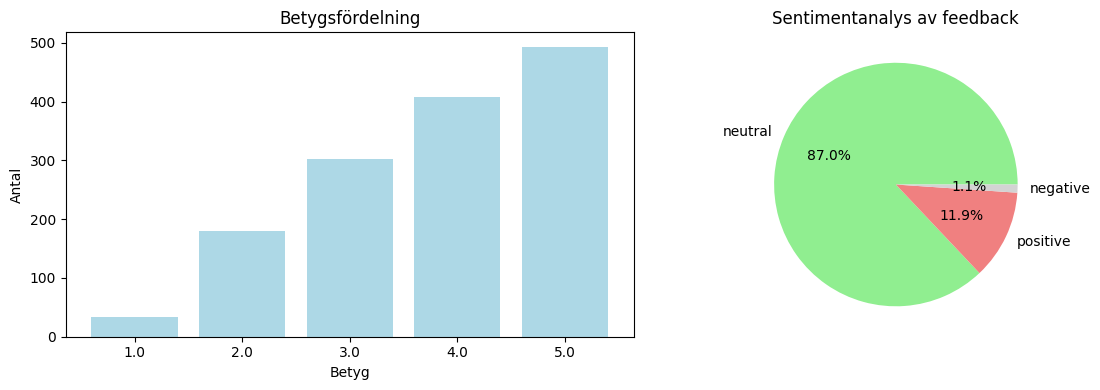


TRENDANALYS (MRR)


TypeError: Invalid comparison between dtype=datetime64[us] and str

In [ ]:

# ERÄKNINGSFUNKTIONER
def mrr_churn(df, month='2024-06'):
    """ MRR och Churn Rate"""
    print(f"\n{'='*50}")
    print(f" MRR (Monthly Recurring Revenue) & CHURN RATE ({month})")
    print('='*50)
    
    # MRR (Monthly Recurring Revenue)
    month_period = pd.Period(month, freq='M')
    start_period = df['medlem_startdatum'].dt.to_period('M')
    end_period = df['medlem_slutdatum'].dt.to_period('M')
    active = df[
        (start_period <= month_period) & 
        ((df['medlem_slutdatum'].isna()) | (end_period >= month_period))
    ]
    
    mrr = active.groupby('medlem_id')['månadskostnad_abs'].last().sum()
    
    # Churn Rate
    prev_month_period = month_period - 1
    churned = df[end_period == month_period]['medlem_id'].nunique()
    total_start = df[start_period <= prev_month_period]['medlem_id'].nunique()
    
    churn_rate = (churned / total_start * 100) if total_start > 0 else 0
    
    print(f"MRR: {mrr:,.0f} SEK")
    print(f"Churn Rate: {churn_rate:.1f}%")
    print(f"Aktiva medlemmar: {active['medlem_id'].nunique()}")
    print(f"Avslutade denna månad: {churned}")
    
    return {'mrr': mrr, 'churn_rate': churn_rate}

def engagement(df, month='2024-06'):
    """Gymfrekvens och engagemang"""
    print(f"\n{'='*50}")
    print(f"ENGAGEMANG ({month})")
    print('='*50)
    
    month_data = df[df['pass_ym'] == month]
    visits_per_member = month_data[month_data['status'] == 'Genomförd'].groupby('medlem_id').size()
    
    if len(visits_per_member) > 0:
        avg_visits = visits_per_member.mean()
        high_eng = (visits_per_member >= 3).sum()
        eng_rate = (high_eng / len(visits_per_member) * 100)
    else:
        avg_visits = 0
        eng_rate = 0
    
    print(f"Genomsnittliga besök/medlem: {avg_visits:.1f}")
    print(f"Andel med 3+ besök/månad: {eng_rate:.1f}%")
    print(f"Totalt antal pass: {len(month_data)}")
    
    # Visuell fördelning
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    if len(visits_per_member) > 0:
        visits_per_member.hist(bins=10, edgecolor='black')
        plt.title('Besök per medlem')
        plt.xlabel('Antal besök')
        plt.ylabel('Antal medlemmar')
    
    plt.subplot(1, 2, 2)
    status_counts = month_data['status'].value_counts()
    status_counts.plot(kind='bar', color=['green', 'orange', 'red'])
    plt.title('Passstatus')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    return {'avg_visits': avg_visits, 'engagement_rate': eng_rate}

def regional_analysis(df):
    """Regional analys"""
    print(f"\n{'='*50}")
    print("REGIONAL ANALYS")
    print('='*50)
    
    regional_stats = df.groupby('region').agg({
        'medlem_id': 'nunique',
        'månadskostnad_abs': 'mean',
        'feedback_betyg': 'mean'
    }).round(1)
    
    regional_stats.columns = ['Antal medlemmar', 'Avg kostnad', 'Avg betyg']
    
    print("Regional statistik:")
    print(regional_stats)
    
    # Visualisering
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    # Medlemmar per region
    axes[0].bar(regional_stats.index, regional_stats['Antal medlemmar'], color='skyblue')
    axes[0].set_title('Medlemmar per region')
    axes[0].set_ylabel('Antal')
    
    # Genomsnittlig kostnad
    axes[1].bar(regional_stats.index, regional_stats['Avg kostnad'], color='lightgreen')
    axes[1].set_title('Genomsnittlig månadskostnad')
    axes[1].set_ylabel('SEK')
    
    # Genomsnittligt betyg
    axes[2].bar(regional_stats.index, regional_stats['Avg betyg'], color='salmon')
    axes[2].set_title('Genomsnittligt betyg')
    axes[2].set_ylabel('Betyg (1-5)')
    
    plt.tight_layout()
    plt.show()
    
    return regional_stats

def class_utilization(df, month='2024-06'):
    """Passbeläggning"""
    print(f"\n{'='*50}")
    print(f"PASSBELÄGGNING ({month})")
    print('='*50)
    
    month_data = df[df['pass_ym'] == month]
    
    # Kapacitet per passtyp (antagande)
    capacity = {
        'Yoga': 20, 'Spinning': 30, 'Hiit': 25,
        'Styrketräning': 15, 'Boxning': 20
    }
    
    # Beräkna beläggning per passnamn
    class_stats = month_data.groupby('passnamn').agg({
        'bokning_id': 'count',
        'status': lambda x: (x == 'Genomförd').sum()
    }).rename(columns={'bokning_id': 'total_bookings', 'status': 'completed'})
    
    class_stats['estimated_capacity'] = class_stats.index.map(
        lambda x: next((v for k, v in capacity.items() if k in str(x)), 25)
    )
    class_stats['utilization'] = (class_stats['completed'] / class_stats['estimated_capacity'] * 100).round(1)
    
    print("Passbeläggning:")
    print(class_stats[['total_bookings', 'completed', 'utilization']])
    
    # Heatmap visualisering
    plt.figure(figsize=(10, 6))
    heatmap_data = month_data.pivot_table(
        values='bokning_id',
        index='passnamn',
        columns='day',
        aggfunc='count',
        fill_value=0
    )
    
    sns.heatmap(heatmap_data, annot=True, fmt='.0f', cmap='YlOrRd')
    plt.title('Passbokningar per dag och typ')
    plt.tight_layout()
    plt.show()
    
    return class_stats

def customer_satisfaction(df):
    """Kundnöjdhet"""
    print(f"\n{'='*50}")
    print("KUNDNÖJDHET")
    print('='*50)
    
    # Enkel sentimentanalys
    def simple_sentiment(text):
        if not isinstance(text, str):
            return 'neutral'
        text = text.lower()
        positive = ['bra', 'fantastisk', 'utmärkt', 'trevlig', 'hjälpsam']
        negative = ['dålig', 'tråkig', 'slitna', 'ful', 'trött']
        
        pos = sum(1 for word in positive if word in text)
        neg = sum(1 for word in negative if word in text)
        
        if pos > neg:
            return 'positive'
        elif neg > pos:
            return 'negative'
        else:
            return 'neutral'
    
    # Applicera sentiment
    feedback_data = df[df['feedback_text'].notna()].copy()
    feedback_data['sentiment'] = feedback_data['feedback_text'].apply(simple_sentiment)
    
    # Statistik
    avg_rating = df['feedback_betyg'].mean()
    sentiment_dist = feedback_data['sentiment'].value_counts(normalize=True) * 100
    
    print(f"Genomsnittligt betyg: {avg_rating:.2f}/5")
    print(f"\nSentimentfördelning:")
    for sentiment, percent in sentiment_dist.items():
        print(f"  {sentiment}: {percent:.1f}%")
    
    # Visualisering
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    
    # Betygsfördelning
    rating_counts = df['feedback_betyg'].dropna().value_counts().sort_index()
    axes[0].bar(rating_counts.index.astype(str), rating_counts.values, color='lightblue')
    axes[0].set_title('Betygsfördelning')
    axes[0].set_xlabel('Betyg')
    axes[0].set_ylabel('Antal')
    
    # Sentiment
    axes[1].pie(sentiment_dist.values, labels=sentiment_dist.index, 
                autopct='%1.1f%%', colors=['lightgreen', 'lightcoral', 'lightgray'])
    axes[1].set_title('Sentimentanalys av feedback')
    
    plt.tight_layout()
    plt.show()
    
    return {'avg_rating': avg_rating, 'sentiment': sentiment_dist}

def trend_analysis(df, kpi='mrr', months=4):
    """Trendanalys"""
    print(f"\n{'='*50}")
    print(f"TRENDANALYS ({kpi.upper()})")
    print('='*50)
    
    # Hämta de senaste månaderna
    recent_months = sorted(df['pass_ym'].unique())[-months:]
    start_period = df['medlem_startdatum'].dt.to_period('M')
    end_period = df['medlem_slutdatum'].dt.to_period('M')
    
    trends = []
    for month in recent_months:
        month_data = df[df['pass_ym'] == month]
        month_period = pd.Period(month, freq='M')
        
        if kpi == 'mrr':
            active = df[
                (start_period <= month_period) & 
                ((df['medlem_slutdatum'].isna()) | (end_period >= month_period))
            ]
            value = active.groupby('medlem_id')['månadskostnad_abs'].last().sum()
            
        elif kpi == 'visits':
            value = len(month_data[month_data['status'] == 'Genomförd'])
            
        elif kpi == 'satisfaction':
            value = month_data['feedback_betyg'].mean()
            
        trends.append({'Month': month, 'Value': value})
    
    trends_df = pd.DataFrame(trends)
    print("Trend över tid:")
    print(trends_df.to_string(index=False))
    
    # Linjediagram
    plt.figure(figsize=(10, 4))
    plt.plot(trends_df['Month'], trends_df['Value'], marker='o', linewidth=2)
    plt.title(f'{kpi.upper()} Trend')
    plt.xlabel('Månad')
    plt.ylabel('Värde')
    plt.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return trends_df

# ========================
# KÖR ALLA KPI:ER
# ========================

# Kör KPI 1-5 för senaste månaden
latest_month = df_feat['pass_ym'].max()
print(f"\nAnalyserar för månad: {latest_month}")

# 1: MRR & Churn
kpi1 = mrr_churn(df_feat, latest_month)

# 2: Engagemang
kpi2 = engagement(df_feat, latest_month)

# 3: Regional analys
kpi3 = regional_analysis(df_feat)

# 4: Passbeläggning
kpi4 = class_utilization(df_feat, latest_month)

# 5: Kundnöjdhet
kpi5 = customer_satisfaction(df_feat)

# 6: Trendanalys (för MRR)
kpi6 = trend_analysis(df_feat, 'mrr', 4)

print("\n" + "="*60)
print("KPI-ANALYS SLUTFÖRD")
print("="*60)

# ========================
# SAMMANFATTNING
# ========================
print("\nSAMMANFATTNING:")
print("-" * 40)
print(f"1. MRR: {kpi1['mrr']:,.0f} SEK")
print(f"2. Churn Rate: {kpi1['churn_rate']:.1f}%")
print(f"3. Genomsnittliga besök: {kpi2['avg_visits']:.1f}/månad")
print(f"4. Kundnöjdhet: {kpi5['avg_rating']:.2f}/5")
print(f"5. Positiv feedback: {kpi5['sentiment'].get('positive', 0):.1f}%")

In [ ]:
def create_kpi_dashboard(df):
    """Skapa en komplett KPI-dashboard"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # 1. MRR Trend (linjediagram)
    mrr_trend = calculate_trend_analysis(df, 'mrr', 6)
    axes[0,0].plot(mrr_trend['month'], mrr_trend['value'], marker='o')
    axes[0,0].set_title('MRR Trend')
    axes[0,0].tick_params(axis='x', rotation=45)
    
    # 2. Churn Rate per Region (stapeldiagram)
    churn_data = df.groupby('region').apply(
        lambda x: (x['medlem_slutdatum'].notna().sum() / len(x) * 100)
    )
    axes[0,1].bar(churn_data.index, churn_data.values)
    axes[0,1].set_title('Churn Rate per Region')
    
    # 3. Gymfrekvens Distribution (histogram)
    visits_per_member = df.groupby(['medlem_id', 'pass_ym']).size().reset_index(name='visits')
    axes[0,2].hist(visits_per_member['visits'], bins=10, edgecolor='black')
    axes[0,2].set_title('Gymfrekvens Distribution')
    
    # 4. Passbeläggning Heatmap
    class_util = calculate_class_utilization(df)
    pivot = class_util.pivot_table(
        values='utilization', 
        index='passnamn', 
        columns=['region_Öst', 'region_Väst', 'region_Syd']
    )
    sns.heatmap(pivot, annot=True, fmt='.1f', cmap='YlOrRd', ax=axes[1,0])
    axes[1,0].set_title('Passbeläggning (%)')
    
    # 5. Medlemstyp Profitabilitet (grupperad stapel)
    profit = calculate_member_type_profitability(df)
    x = np.arange(len(profit))
    width = 0.35
    axes[1,1].bar(x - width/2, profit['antal_medlemmar'], width, label='Antal')
    axes[1,1].bar(x + width/2, profit['avg_månadskostnad'], width, label='Avg Kostnad')
    axes[1,1].set_xticks(x)
    axes[1,1].set_xticklabels(profit.index, rotation=45)
    axes[1,1].set_title('Medlemstyp Analys')
    axes[1,1].legend()
    
    # 6. Sentiment Analys (cirkeldiagram)
    _, sentiment = calculate_customer_satisfaction(df)
    axes[1,2].pie(sentiment.values, labels=sentiment.index, autopct='%1.1f%%')
    axes[1,2].set_title('Kundsentiment')
    
    plt.tight_layout()
    plt.show()

In [ ]:
class AdvancedSentimentAnalyzer:
    """Använd BERT för sentimentanalys på feedback"""
    
    def __init__(self):
        # Enkel BERT implementation
        self.sentiment_pipeline = pipeline(
            "sentiment-analysis",
            model="nlptown/bert-base-multilingual-uncased-sentiment"
        )
    
    def analyze_feedback_sentiment(self, feedback_texts):
        """Analysera sentiment på feedback"""
        results = []
        for text in feedback_texts:
            if isinstance(text, str) and len(text) > 10:
                try:
                    result = self.sentiment_pipeline(text[:512])[0]
                    results.append({
                        'text': text,
                        'label': result['label'],
                        'score': result['score']
                    })
                except:
                    results.append({'text': text, 'label': 'ERROR', 'score': 0})
        
        return pd.DataFrame(results)